# Prudential Life Insurance Assessment

## Part 3 - H2O AutoML with MLflow


### Contents
[Part 1 - Initial Setup](#setup)  
[Part 2 - Run H2O AutoML Training with MLflow](#automl)  
[Part 3 - Predict with H2O AutoML Best Model](#predict)  
[Part 4 - H2O Model Explainability](#explain)  
[Part 5 - References](#references)

___
<a name="setup"></a>
## (1) Initial Setup

### Install pre-requisite dependencies

In [1]:
# !pip install requests
# !pip install tabulate
# !pip install future

### Install H2O in Python

In [2]:
# !pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

### Install MLflow

In [3]:
# !pip install mlflow

### Import dependencies and datasets

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import h2o
from h2o.automl import H2OAutoML, get_leaderboard

import mlflow
import mlflow.h2o
from mlflow.tracking import MlflowClient

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Import processed datasets
main_df = pd.read_csv('data/processed/train_processed.csv')
test_df = pd.read_csv('data/processed/test_processed.csv')

### Initiate H2O cluster

In [6]:
# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.281-b09, mixed mode)
  Starting server from C:\ProgramData\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\kenne\AppData\Local\Temp\tmpwzwwz3nu
  JVM stdout: C:\Users\kenne\AppData\Local\Temp\tmpwzwwz3nu\h2o_kenne_started_from_python.out
  JVM stderr: C:\Users\kenne\AppData\Local\Temp\tmpwzwwz3nu\h2o_kenne_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_kenne_gas17c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.768 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### Setup MLflow

- First open Powershell terminal and change path to the directory hosting this notebook (e.g. `cd D:\GitHub\Prudential-Life-Insurance-Assessment\`
- Enter `mlflow ui` to initiate MLFlow server
- Once done, access the MLFlow UI served on http://127.0.0.1:5000

In [7]:
# Initialize MLFlow client
client = MlflowClient()

In [8]:
# Set up MlFlow experiment
experiment_name = 'prudential-life'

try:
    experiment = mlflow.create_experiment(experiment_name)
except:
    experiment = client.get_experiment_by_name(experiment_name)
    
mlflow.set_experiment(experiment_name)

___
<a name="automl"></a>
## (2) Run H2O AutoML Training with MLFlow

### Data Preparation

In [9]:
main_df.head()

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_4,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response,Product_Info_2_Alpha,Product_Info_2_Num,Med_Keywords_Count
0,1,16,10,0.076923,2,1,1,0.641791,0.581818,0.148536,0.323008,0.028,12,1,0.0,3,NaN,1,2,6,3,1,2,1,1,1,3,1,0.000667,1,1,2,2,NaN,NaN,4.0,112,2,1,1,3,2,2,1,3,2,3,3,3,3,1,1,2,1,2,3,1,3,3,1,3,2,3,1,3,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,3,3,0
1,1,0,26,0.076923,2,3,1,0.059701,0.600000,0.131799,0.272288,0.000,1,3,0.0,2,0.0018,1,2,6,3,1,2,1,2,1,3,1,0.000133,1,3,2,2,0.188406,0.084507,5.0,412,2,1,1,3,2,2,1,3,2,3,3,1,3,1,1,2,1,2,3,1,3,3,1,3,2,3,3,1,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,0
2,1,18,26,0.076923,2,3,1,0.029851,0.745455,0.288703,0.428780,0.030,9,1,0.0,2,0.0300,1,2,8,3,1,1,1,2,1,1,3,NaN,3,2,3,3,0.304348,0.225352,10.0,3,2,2,1,3,2,2,2,3,2,3,3,1,3,1,1,2,1,2,3,2,2,3,1,3,2,3,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,4,1,0
3,1,17,10,0.487179,2,3,1,0.164179,0.672727,0.205021,0.352438,0.042,9,1,0.0,3,0.2000,2,2,8,3,1,2,1,2,1,1,3,NaN,3,2,3,3,0.420290,0.352113,0.0,350,2,2,1,3,2,2,2,3,2,3,3,1,3,1,1,2,2,2,3,1,3,3,1,3,2,3,3,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,3,4,1
4,1,15,26,0.230769,2,3,1,0.417910,0.654545,0.234310,0.424046,0.027,9,1,0.0,2,0.0500,1,2,6,3,1,2,1,2,1,1,3,NaN,3,2,3,2,0.463768,0.408451,NaN,162,2,2,1,3,2,2,2,3,2,3,3,1,3,1,1,2,1,2,3,2,2,3,1,3,2,3,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,3,2,0


In [10]:
main_df['Response'].value_counts()

8    19489
6    11233
7     8027
2     6552
1     6207
5     5432
4     1428
3     1013
Name: Response, dtype: int64

In [11]:
# Define predictors and target variables
target = 'Response'
predictors = main_df.columns.tolist()
predictors.remove(target)

In [12]:
# Create train val split (80/20). This step is optional as cross-validation will be done on entire train set (i.e. main_df)
# train_set, val_set = train_test_split(main_df, test_size=0.2)

In [13]:
# Convert pandas dataframes into H2O Frames
main_frame = h2o.H2OFrame(main_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [14]:
# Factorize target variable so that autoML tackles classification problem (instead of regression)
main_frame[target] = main_frame[target].asfactor()

# Visualize H2O frame structure
main_frame.head()

Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_4,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response,Product_Info_2_Alpha,Product_Info_2_Num,Med_Keywords_Count
1,16,10,0.0769231,2,1,1,0.641791,0.581818,0.148536,0.323008,0.028,12,1,0,3,nan,1,2,6,3,1,2,1,1,1,3,1,0.000666667,1,1,2,2,nan,nan,4,112,2,1,1,3,2,2,1,3,2,3,3,3,3,1,1,2,1,2,3,1,3,3,1,3,2,3,1,3,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,3,3,0
1,0,26,0.0769231,2,3,1,0.0597015,0.6,0.131799,0.272288,0,1,3,0,2,0.0018,1,2,6,3,1,2,1,2,1,3,1,0.000133333,1,3,2,2,0.188406,0.084507,5,412,2,1,1,3,2,2,1,3,2,3,3,1,3,1,1,2,1,2,3,1,3,3,1,3,2,3,3,1,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,0
1,18,26,0.0769231,2,3,1,0.0298507,0.745455,0.288703,0.42878,0.03,9,1,0,2,0.03,1,2,8,3,1,1,1,2,1,1,3,nan,3,2,3,3,0.304348,0.225352,10,3,2,2,1,3,2,2,2,3,2,3,3,1,3,1,1,2,1,2,3,2,2,3,1,3,2,3,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,4,1,0
1,17,10,0.487179,2,3,1,0.164179,0.672727,0.205021,0.352438,0.042,9,1,0,3,0.2,2,2,8,3,1,2,1,2,1,1,3,nan,3,2,3,3,0.42029,0.352113,0,350,2,2,1,3,2,2,2,3,2,3,3,1,3,1,1,2,2,2,3,1,3,3,1,3,2,3,3,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,3,4,1
1,15,26,0.230769,2,3,1,0.41791,0.654545,0.23431,0.424046,0.027,9,1,0,2,0.05,1,2,6,3,1,2,1,2,1,1,3,nan,3,2,3,2,0.463768,0.408451,nan,162,2,2,1,3,2,2,2,3,2,3,3,1,3,1,1,2,1,2,3,2,2,3,1,3,2,3,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,3,2,0
1,15,26,0.230769,3,1,1,0.507463,0.836364,0.299163,0.364887,0.325,15,1,0,2,1,1,2,8,3,1,1,1,2,1,3,2,0.005,1,3,2,2,nan,0.507042,6,491,2,2,1,3,2,2,2,3,2,3,3,1,3,2,1,2,2,2,3,1,3,3,1,3,2,3,3,1,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0

### Start H2O AutoML training with MLflow tracking

In [15]:
# Wrap autoML training with MLflow
with mlflow.start_run():
    aml = H2OAutoML(max_models=30, # Run AutoML for n base models
                    seed=42, 
                    balance_classes=True, # Our target classes are imbalanced, so we set this to True
                    sort_metric='logloss', # Sort models by logloss (main metric for multi-classification)
                    verbosity='info' # Turn on verbose info
#                     exclude_algos = ['GLM', 'DRF'], # Specify which algorithms to exclude
                   )
    
    aml.train(x=predictors, y=target, training_frame=main_frame)
    
    # Set metrics to log
    mlflow.log_metric("log_loss", aml.leader.logloss())
    mlflow.log_metric("mean_per_class_error", aml.leader.mean_per_class_error())
    
    # Log best model (mlflow.h2o module provides an API for logging and loading H2O models)
    mlflow.h2o.log_model(aml.leader, "model")
    
    # Print and view AutoML Leaderboard
    lb = get_leaderboard(aml, extra_columns='ALL')
    print(lb.head(rows=lb.nrows))

AutoML progress: |
01:05:09.743: Project: AutoML_1_20211108_10509
01:05:09.810: Setting stopping tolerance adaptively based on the training frame: 0.004103706068429825
01:05:09.811: Build control seed: 42
01:05:09.811: training frame: Frame key: AutoML_1_20211108_10509_training_py_1_sid_a252    cols: 124    rows: 59381  chunks: 8    size: 6863274  checksum: -5815221732867628563
01:05:09.812: validation frame: NULL
01:05:09.812: leaderboard frame: NULL
01:05:09.812: blending frame: NULL
01:05:09.812: response column: Response
01:05:09.812: fold column: null
01:05:09.812: weights column: null
01:05:09.832: AutoML: XGBoost is not available; skipping it.
01:05:09.833: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (6g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid_1 (4g, 60w), lr_annealing (6g,


05:22:26.73: AutoML: starting StackedEnsemble_BestOfFamily_5_AutoML_1_20211108_10509 model training


05:23:51.96: AutoML: starting StackedEnsemble_AllModels_4_AutoML_1_20211108_10509 model training


05:38:31.48: New leader: StackedEnsemble_AllModels_4_AutoML_1_20211108_10509, logloss: 1.2356718100604716
05:38:31.48: No base models, due to timeouts or the exclude_algos option. Skipping StackedEnsemble 'monotonic'.
05:38:31.48: AutoML: starting StackedEnsemble_BestOfFamily_6_AutoML_1_20211108_10509 model training


05:40:18.339: AutoML: starting StackedEnsemble_AllModels_5_AutoML_1_20211108_10509 model training


05:49:34.23: AutoML: starting StackedEnsemble_BestOfFamily_7_AutoML_1_20211108_10509 model training


06:10:59.203: AutoML: starting StackedEnsemble_AllModels_6_AutoML_1_20211108_10509 model training

| (done) 100%

07:42:33.847: New leader: StackedEnsemble_AllModels_6_AutoML_1_20211108_10509, logloss: 1.23303139752078
07:42:33.878: Actual modeling steps: [{GLM : [def_1 (1g, 

model_id,logloss,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_6_AutoML_1_20211108_10509,1.23303,0.607322,0.647825,0.419677,5.49421e+06,0.47893,StackedEnsemble
StackedEnsemble_AllModels_4_AutoML_1_20211108_10509,1.23567,0.607217,0.649706,0.422118,879186,0.439641,StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_1_20211108_10509,1.2363,0.607644,0.649515,0.42187,167126,0.212903,StackedEnsemble
StackedEnsemble_AllModels_3_AutoML_1_20211108_10509,1.23643,0.60743,0.650081,0.422606,447086,0.378197,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20211108_10509,1.23863,0.609664,0.649953,0.422439,78833,0.147794,StackedEnsemble
StackedEnsemble_BestOfFamily_7_AutoML_1_20211108_10509,1.24162,0.609784,0.650516,0.423171,1.28507e+06,0.121108,StackedEnsemble
StackedEnsemble_BestOfFamily_5_AutoML_1_20211108_10509,1.24368,0.61124,0.652099,0.425234,84351,0.120618,StackedEnsemble
StackedEnsemble_AllModels_5_AutoML_1_20211108_10509,1.24378,0.613673,0.649455,0.421792,555575,0.447785,StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_1_20211108_10509,1.2442,0.612073,0.652139,0.425285,94084,0.118597,StackedEnsemble
StackedEnsemble_BestOfFamily_4_AutoML_1_20211108_10509,1.24461,0.611282,0.652851,0.426215,74326,0.119465,StackedEnsemble


### View AutoML logs

In [37]:
# Get AutoML event log
log = aml.event_log
log

timestamp,level,stage,message,name,value
01:05:09.743,Info,Workflow,Project: AutoML_1_20211108_10509,,
01:05:09.810,Info,Validation,Setting stopping tolerance adaptively based on the training frame: 0.004103706068429825,,
01:05:09.811,Info,Validation,Build control seed: 42,,
01:05:09.811,Info,DataImport,training frame: Frame key: AutoML_1_20211108_10509_training_py_1_sid_a252 cols: 124 rows: 59381 chunks: 8 size: 6863274 checksum: -5815221732867628563,,
01:05:09.812,Info,DataImport,validation frame: NULL,,
01:05:09.812,Info,DataImport,leaderboard frame: NULL,,
01:05:09.812,Info,DataImport,blending frame: NULL,,
01:05:09.812,Info,DataImport,response column: Response,,
01:05:09.812,Info,DataImport,fold column: null,,
01:05:09.812,Info,DataImport,weights column: null,,


In [38]:
# Get training timing info
info = aml.training_info
info

{'creation_epoch': '1636304710',
 'start_epoch': '1636304710',
 'start_GLM_def_1': '1636304710',
 'start_GBM_def_5': '1636305817',
 'start_StackedEnsemble_best_of_family_1': '1636306621',
 'start_DRF_def_1': '1636306711',
 'start_GBM_def_2': '1636307712',
 'start_GBM_def_3': '1636308256',
 'start_GBM_def_4': '1636308820',
 'start_StackedEnsemble_best_of_family_2': '1636309453',
 'start_StackedEnsemble_all_2': '1636309505',
 'start_DRF_XRT': '1636309584',
 'start_GBM_def_1': '1636310506',
 'start_DeepLearning_def_1': '1636311005',
 'start_StackedEnsemble_best_of_family_3': '1636311042',
 'start_StackedEnsemble_all_3': '1636311136',
 'start_GBM_grid_1': '1636311304',
 'start_DeepLearning_grid_1': '1636314967',
 'start_StackedEnsemble_best_of_family_4': '1636316814',
 'start_StackedEnsemble_all_4': '1636316889',
 'start_DeepLearning_grid_2': '1636317336',
 'start_DeepLearning_grid_3': '1636318625',
 'start_StackedEnsemble_best_of_family_5': '1636320146',
 'start_StackedEnsemble_all_5': '1

### View best model

In [18]:
# Leader (best) model stored here
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_6_AutoML_1_20211108_10509

No model summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.27702962286597244
RMSE: 0.5263360360700875

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.419676914319152
RMSE: 0.6478247558708697


#### Learning Curve Plot

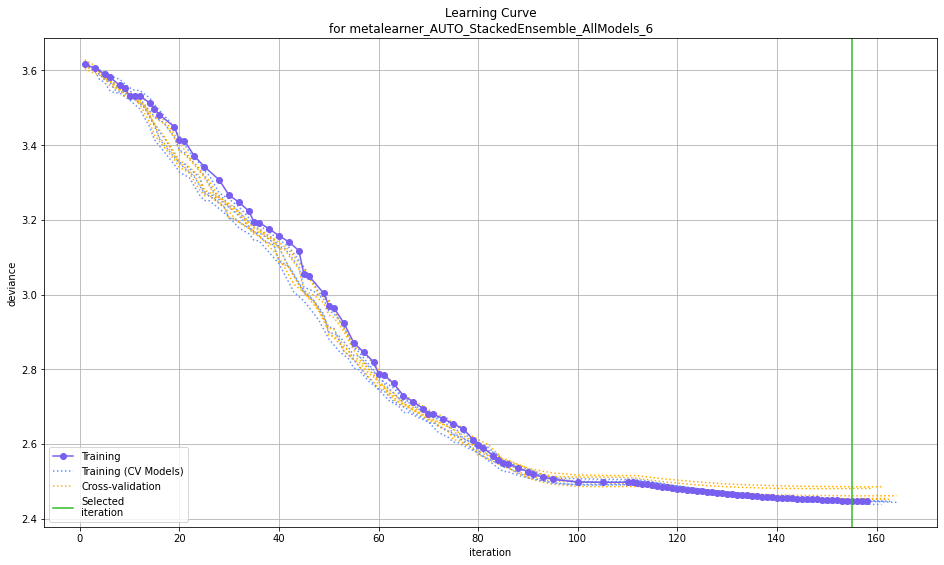

In [37]:
learning_curve_plot = best_model.learning_curve_plot()

___
<a name="predict"></a>
## (3) Predict with H2O AutoML Best Model

### Prepare test data

In [25]:
X_test = test_df.drop("Id",axis=1).copy()
X_test_frame = h2o.H2OFrame(X_test, 
                            column_types={'Family_Hist_2': "real"} # Convert family_hist_2 to real values (as H2O erroneously converted it to categorical)
                            )

# See https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html on frame column types for more info

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


### Load saved leader model from MLflow

In [25]:
# Get all runs from current MLflow experiment
all_mlflow_runs = client.list_run_infos(experiment.experiment_id)
print(all_mlflow_runs)

if len(all_mlflow_runs) > 0:
    # Get most recent run
    run_info = all_mlflow_runs[0]
    run_id = run_info.run_uuid # ID of the experiment run
    exp_id = experiment.experiment_id # ID of the MLflow experiment prudential-life
    best_model = mlflow.h2o.load_model(f"mlruns/{exp_id}/{run_id}/artifacts/model/") # Leader model from autoML

[<RunInfo: artifact_uri='file:///D:/Google%20Drive/Data%20Vault/GitHub/Prudential-Life-Insurance-Assessment/mlruns/1/3832390d98be4b30bc441aa6b7675357/artifacts', end_time=1636328749914, experiment_id='1', lifecycle_stage='active', run_id='3832390d98be4b30bc441aa6b7675357', run_uuid='3832390d98be4b30bc441aa6b7675357', start_time=1636304709554, status='FINISHED', user_id='kenne'>, <RunInfo: artifact_uri='file:///D:/Google%20Drive/Data%20Vault/GitHub/Prudential-Life-Insurance-Assessment/mlruns/1/57c13571c1cf4566af6c98cbe78e1597/artifacts', end_time=1636299741579, experiment_id='1', lifecycle_stage='active', run_id='57c13571c1cf4566af6c98cbe78e1597', run_uuid='57c13571c1cf4566af6c98cbe78e1597', start_time=1636292953575, status='FINISHED', user_id='kenne'>]


In [33]:
# Generate predictions
preds = best_model.predict(X_test_frame)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [34]:
# Convert H2O frame to pandas df
preds_as_df = preds.as_data_frame()

### Get Kaggle Submission Score

In [35]:
# Format in the submission format
submission = pd.DataFrame({'Id': test_df['Id'].values, 
                           'Response': preds_as_df['predict'].values})
submission.head()

,Id,Response
0,1,1
1,3,8
2,4,6
3,9,8
4,12,8


In [36]:
# Save as CSV for submission online on Kaggle
submission.to_csv(f'submissions/prudential_{run_id}.csv', index=False)

##### Final Score: 0.56671
- Accuracy score is much higher than expected (random guess) score of 0.125 (since there are 8 labels)
- Score is slightly higher than the 0.56279 XGBoost baseline model (from `02_XGBoost_Baseline_Model.ipynb`)
- Nonetheless, this score is still a fair amount away from the top Kaggle score of 0.67938 
- This means that more focus and effort should be spent on the feature engineering/selection, rather than the modelling

___
<a name="explain"></a>
## (4) H2O Model Explainability
- More info: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html#output-explanations

In [26]:
# Setup validation set (15%) for model explainability
_, _, val_frame = main_frame.split_frame(ratios=[.7, .15])

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_6_AutoML_1_20211108_10509


Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,1,2,3,4,5,6,7,8,Error,Rate
0,604.0,13.0,1.0,3.0,26.0,89.0,61.0,127.0,0.346320,320 / 924
1,4.0,628.0,7.0,6.0,40.0,99.0,47.0,116.0,0.336853,319 / 947
2,3.0,5.0,95.0,10.0,7.0,33.0,6.0,5.0,0.420732,69 / 164
3,2.0,1.0,1.0,79.0,0.0,79.0,5.0,44.0,0.625592,132 / 211
4,13.0,20.0,4.0,1.0,596.0,94.0,50.0,60.0,0.288783,242 / 838
5,19.0,23.0,1.0,8.0,19.0,1220.0,121.0,274.0,0.275964,"465 / 1,685"
6,5.0,10.0,0.0,2.0,2.0,95.0,770.0,345.0,0.373474,"459 / 1,229"
7,4.0,11.0,0.0,6.0,3.0,83.0,51.0,2776.0,0.053851,"158 / 2,934"
8,654.0,711.0,109.0,115.0,693.0,1792.0,1111.0,3747.0,0.242275,"2,164 / 8,932"


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

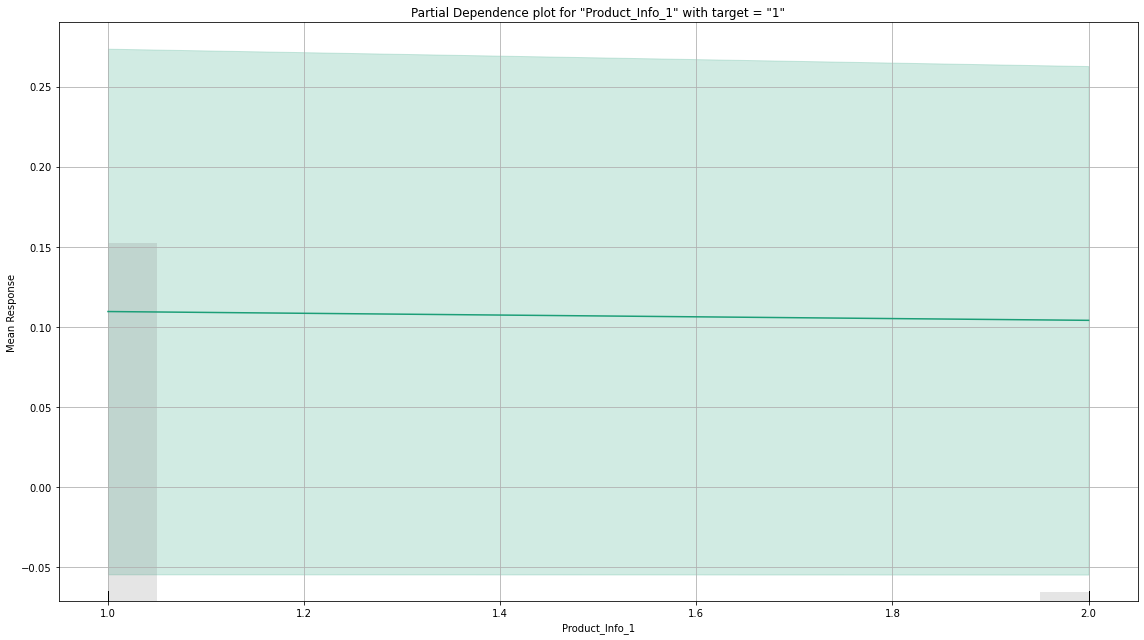

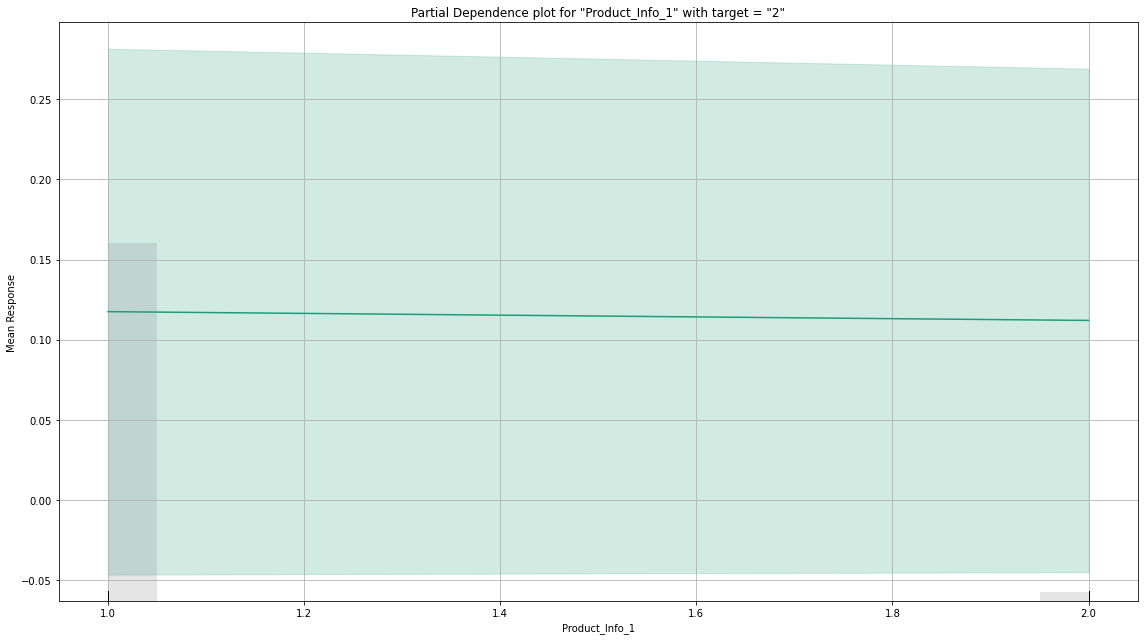

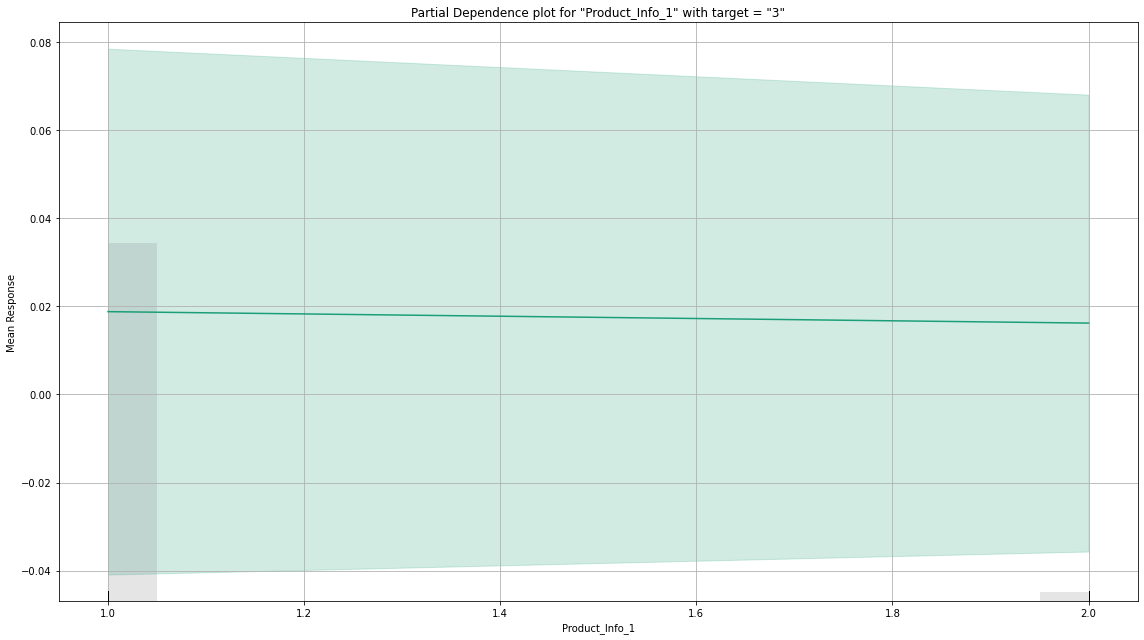

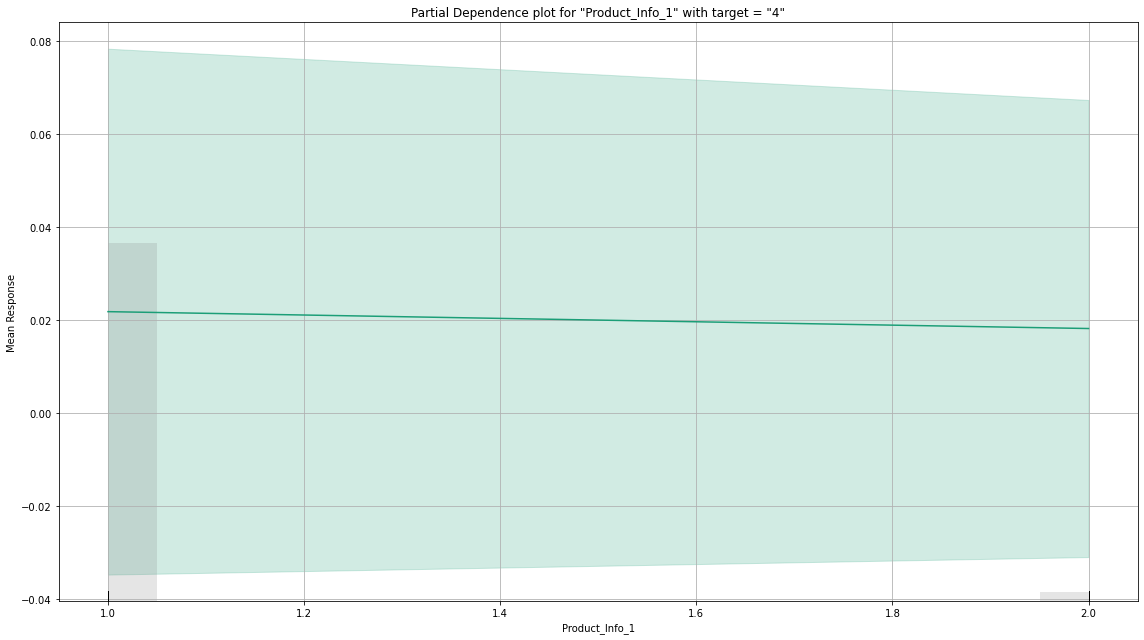

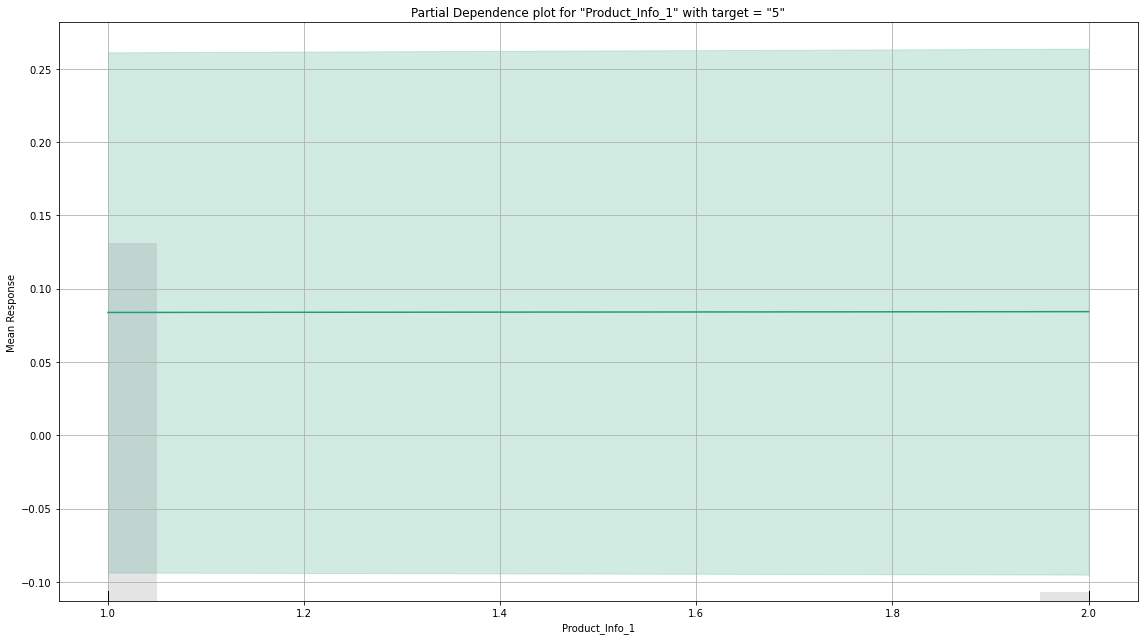

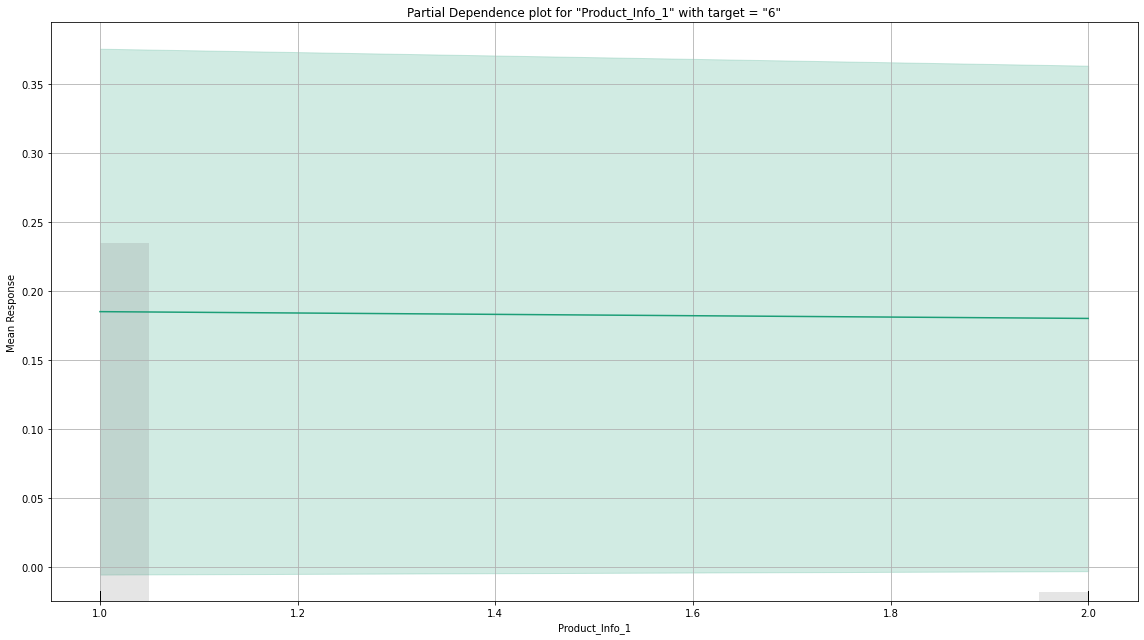

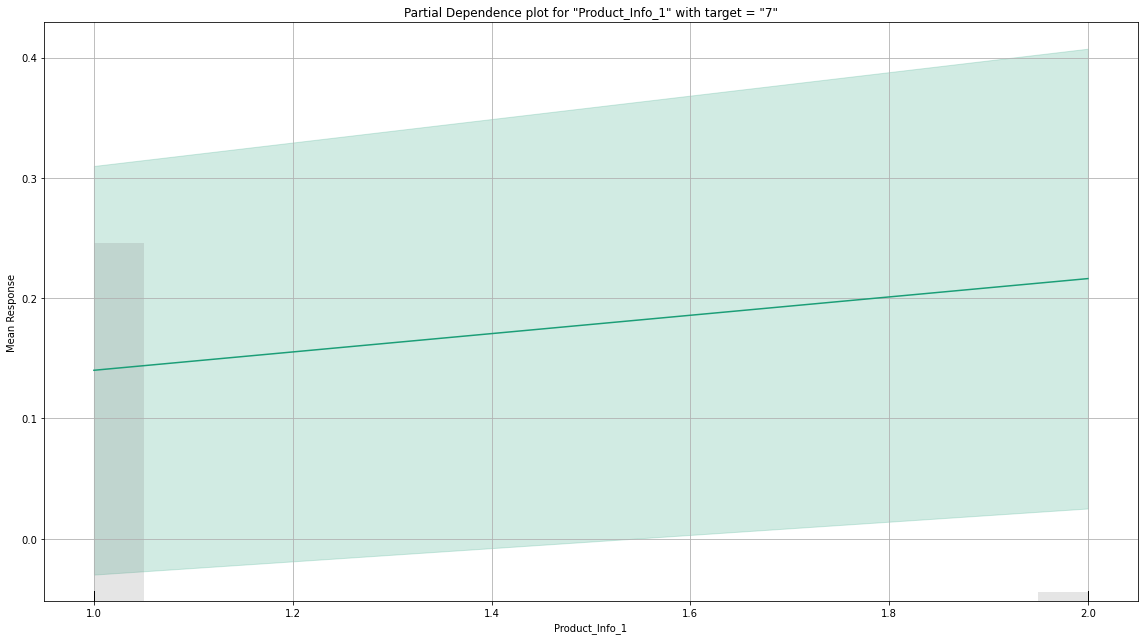

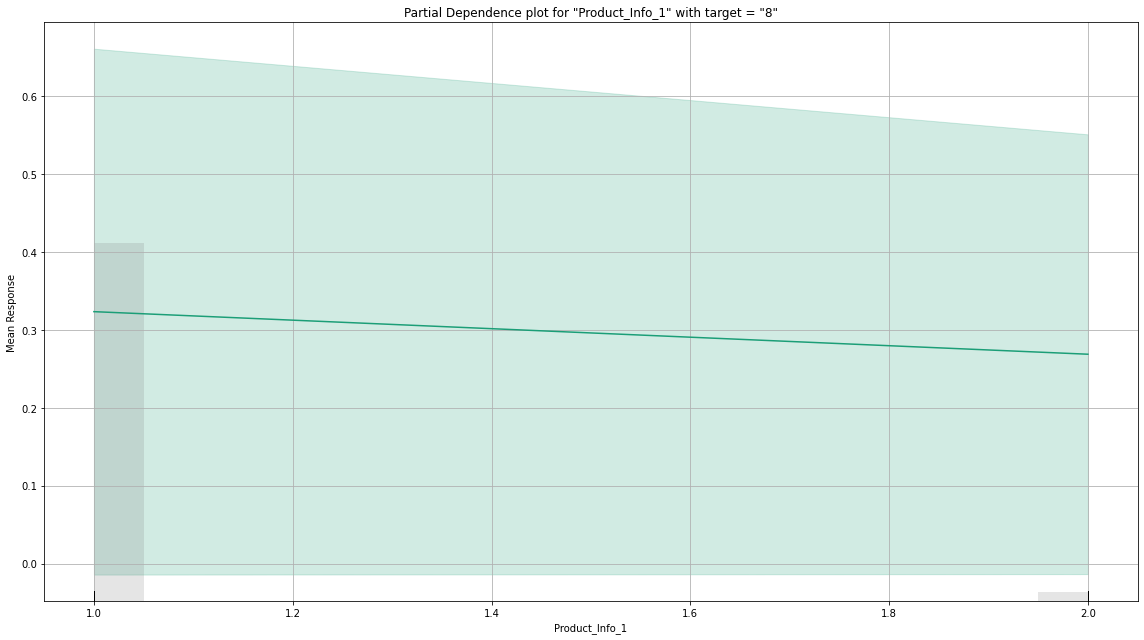

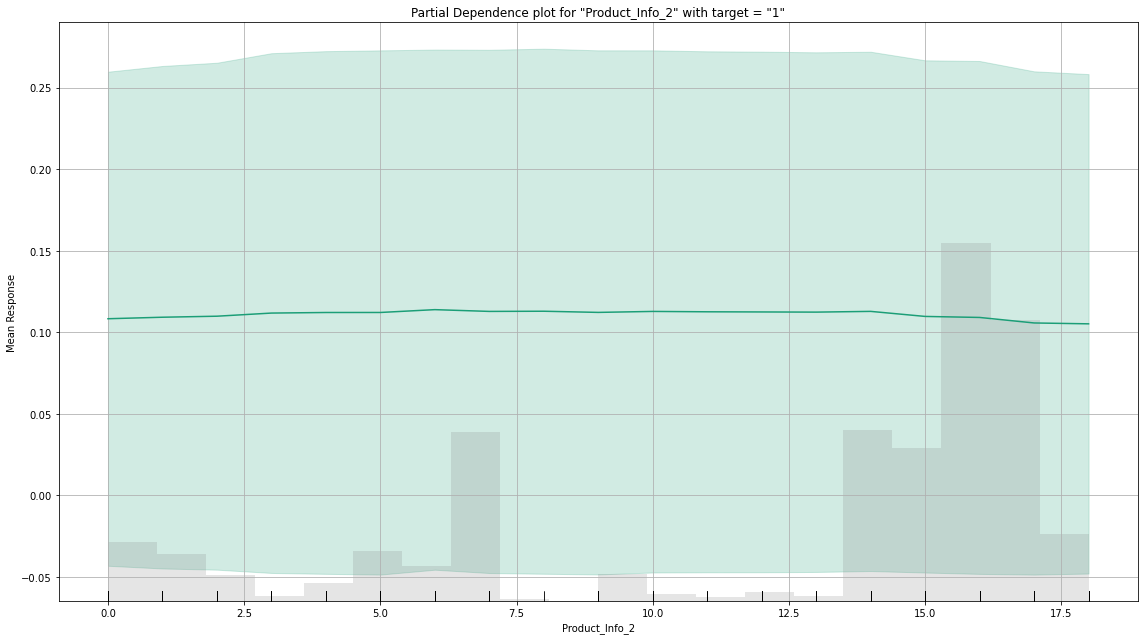

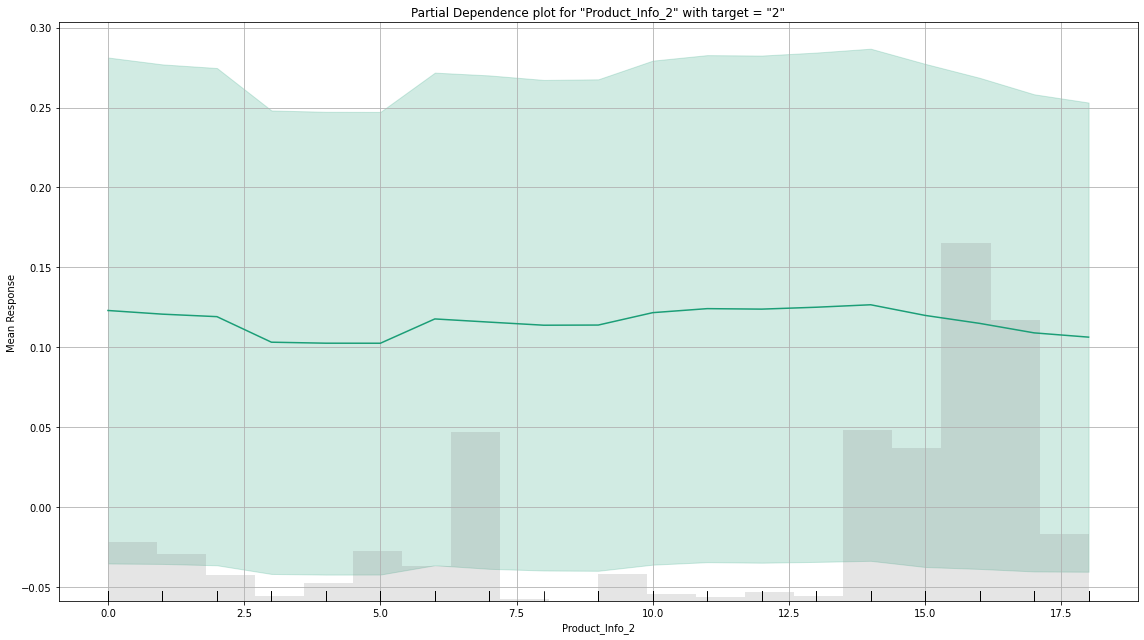

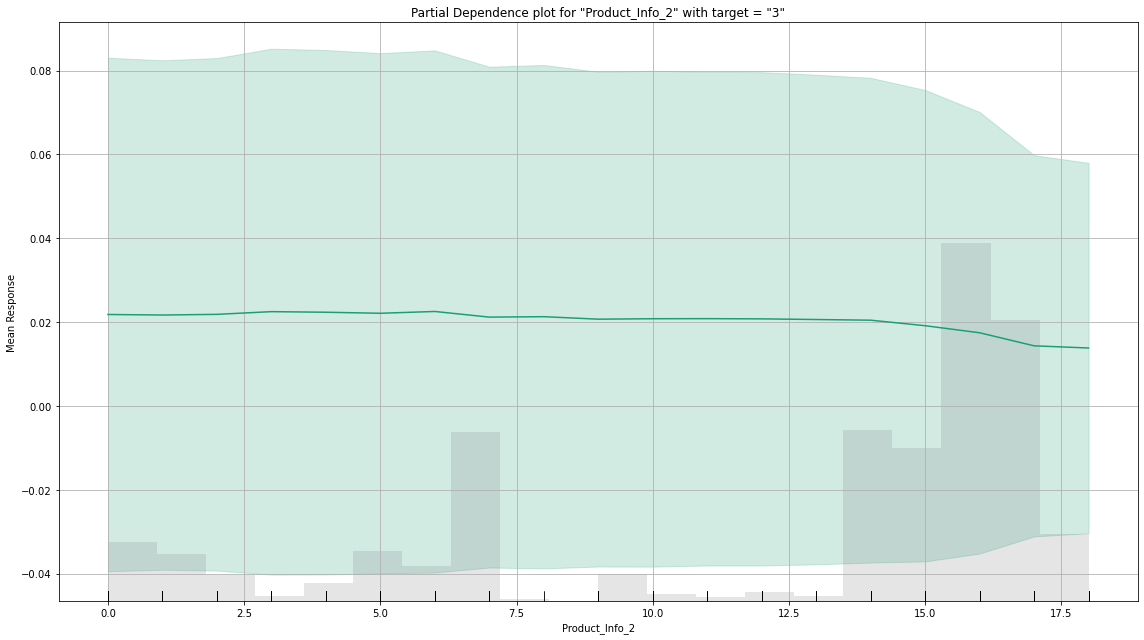

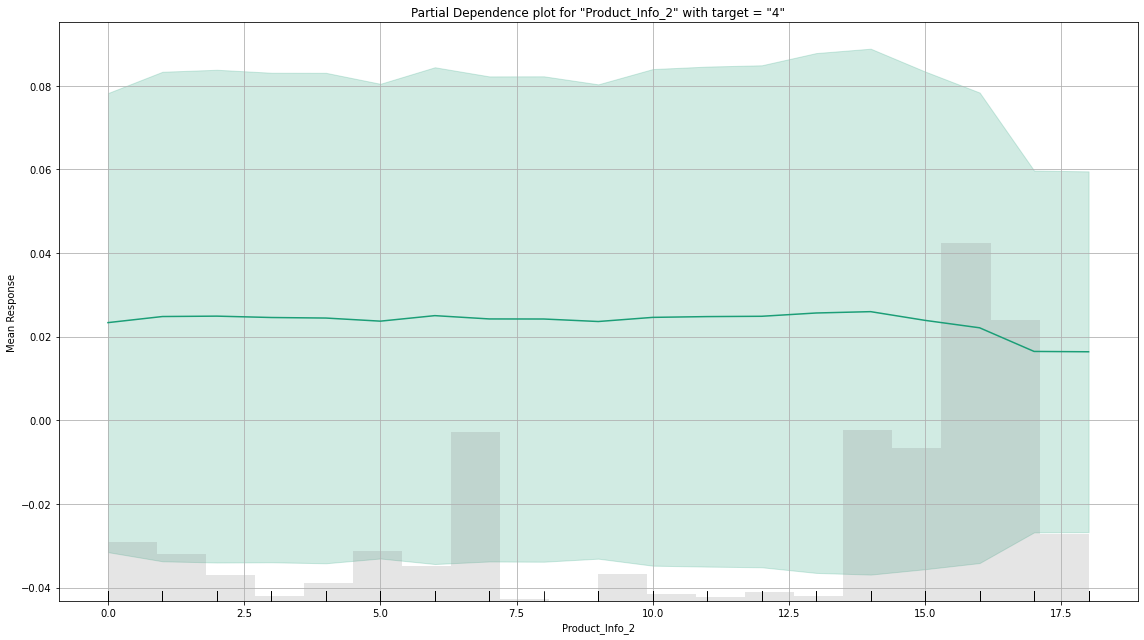

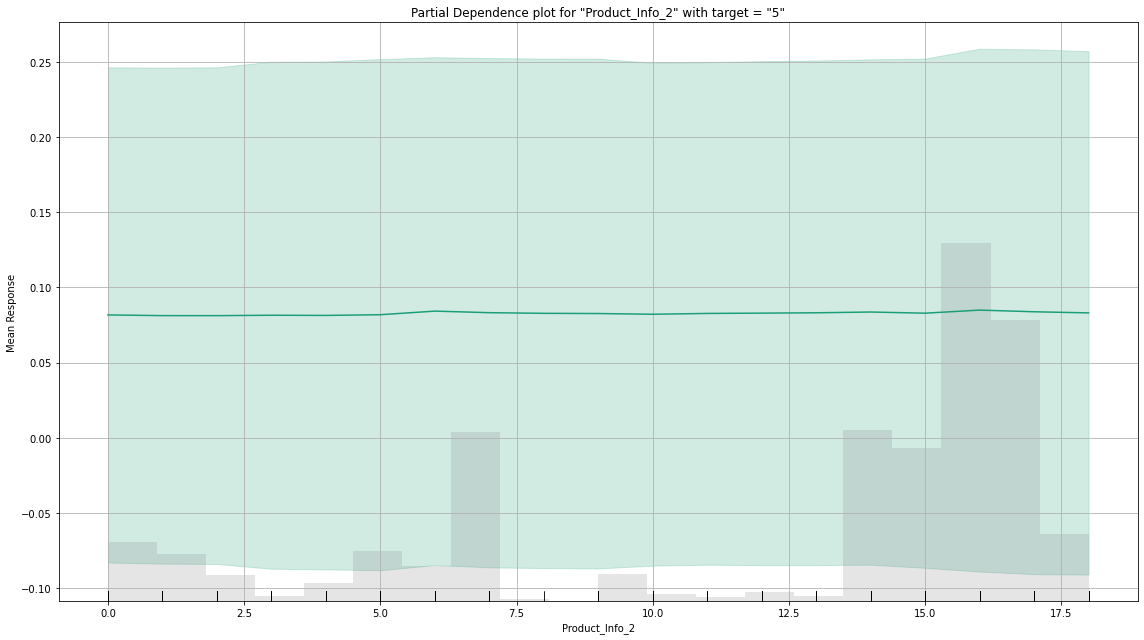

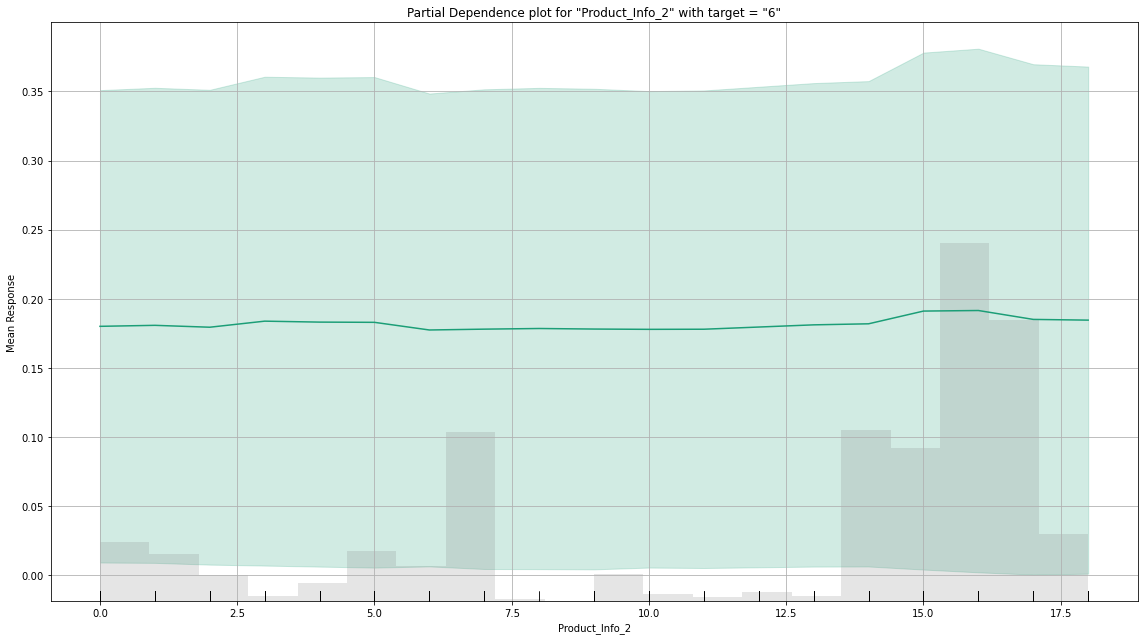

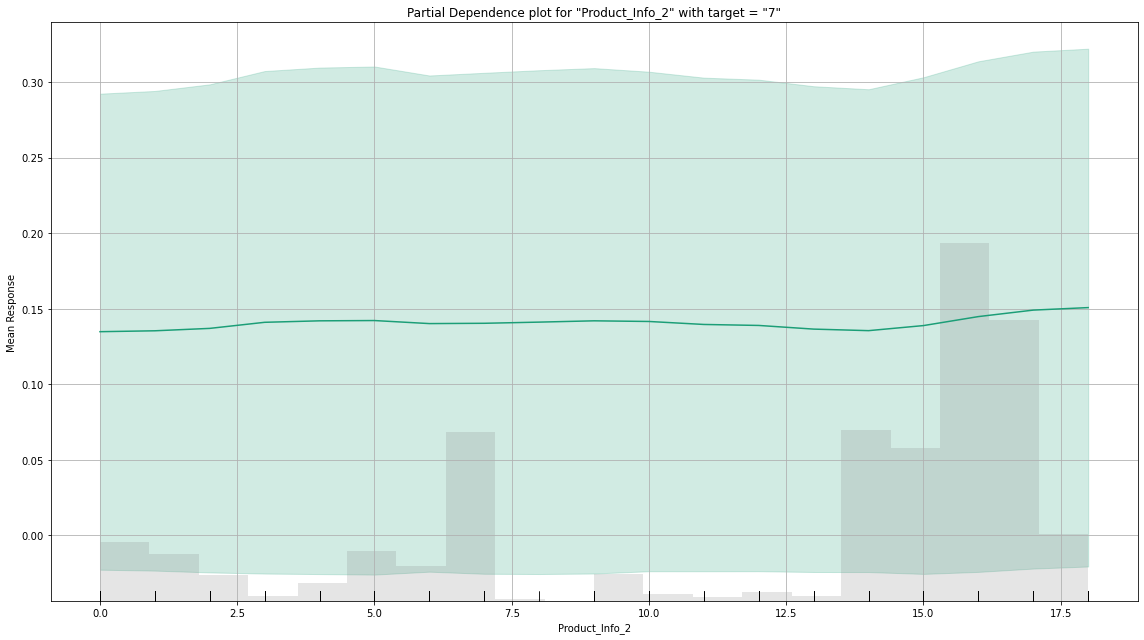

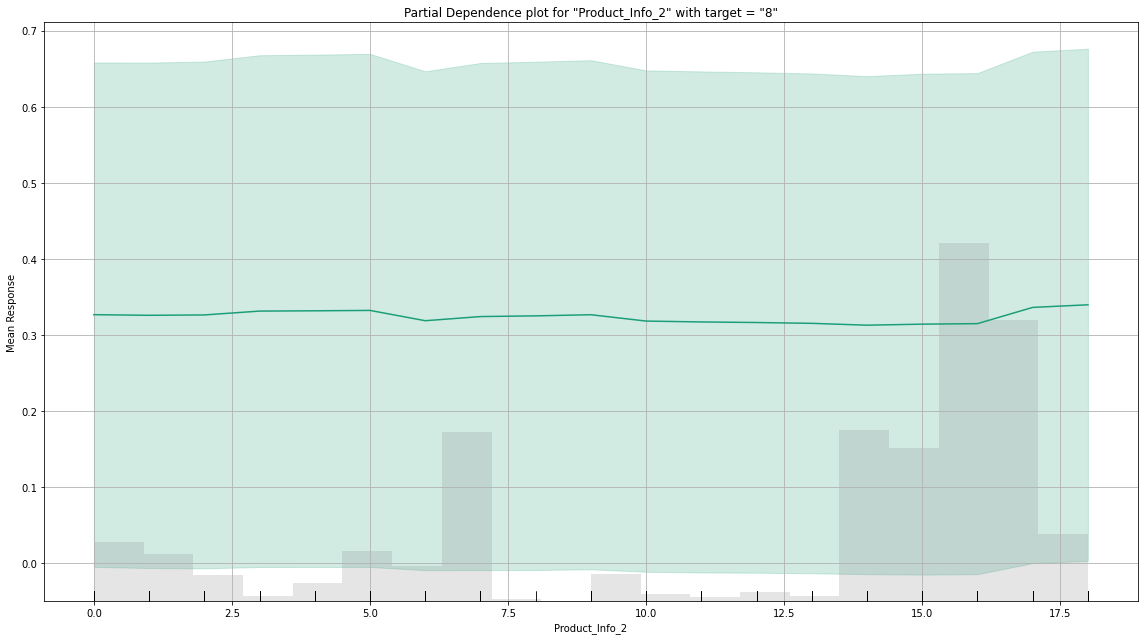

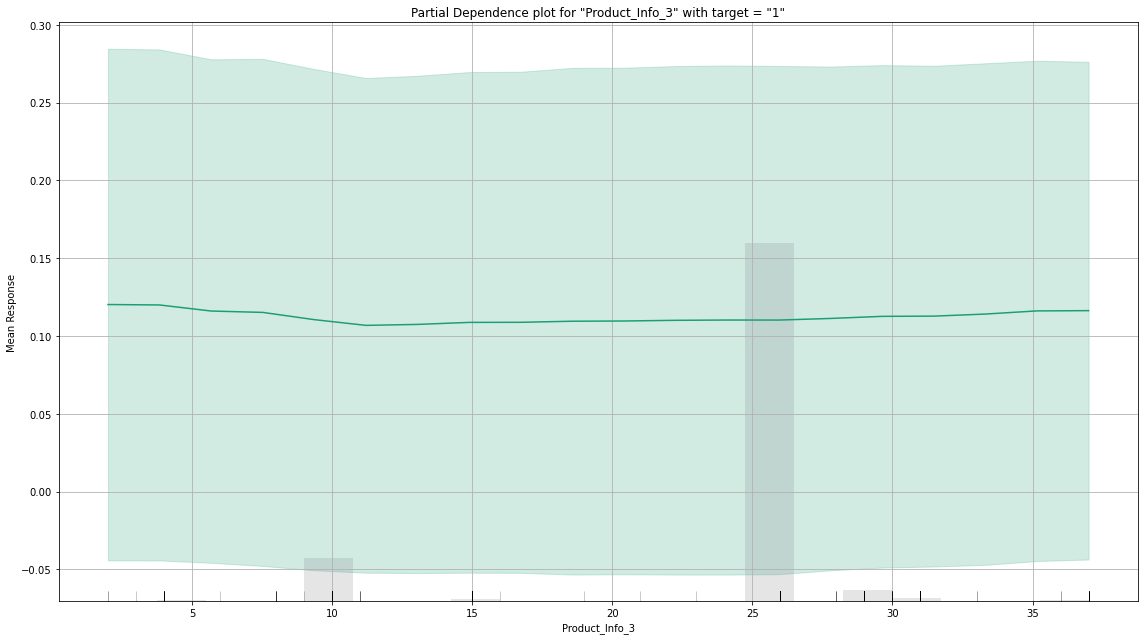

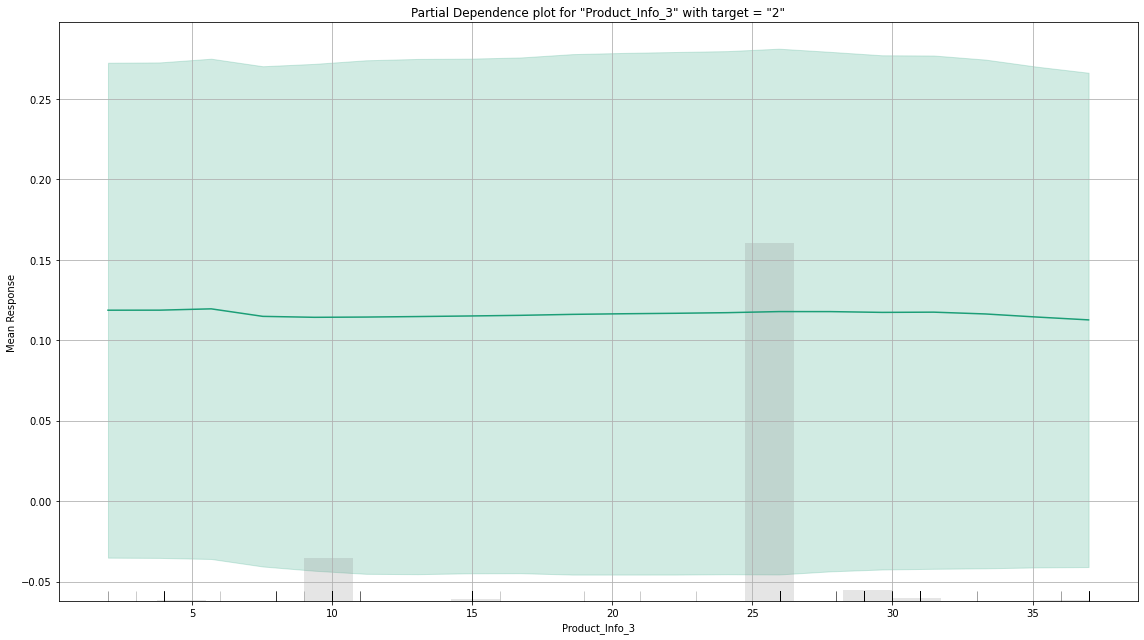

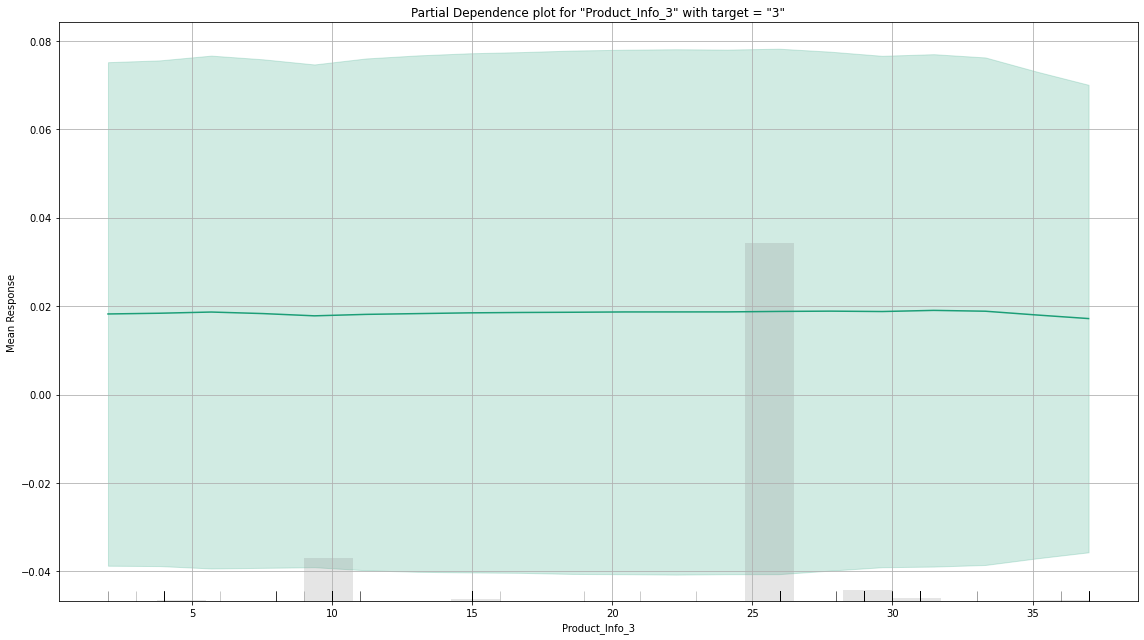

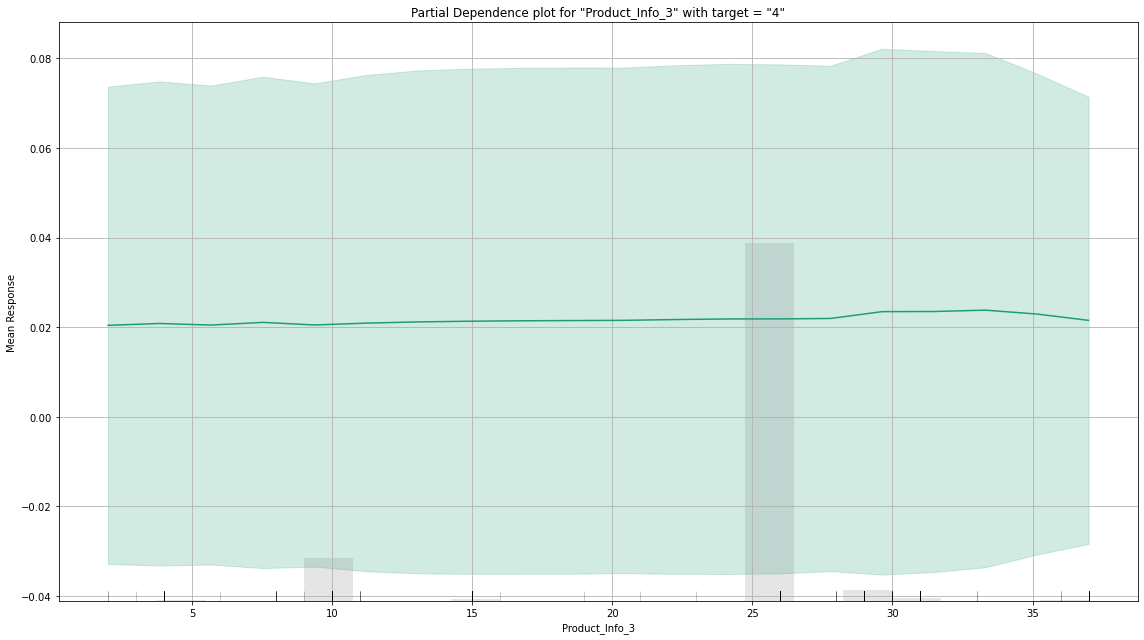

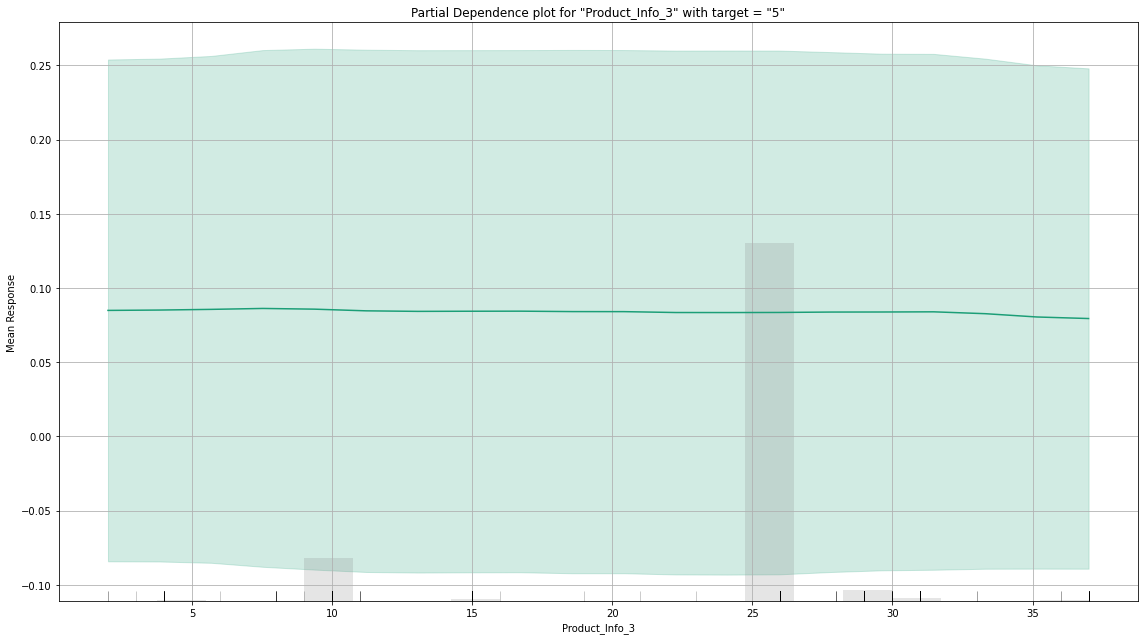

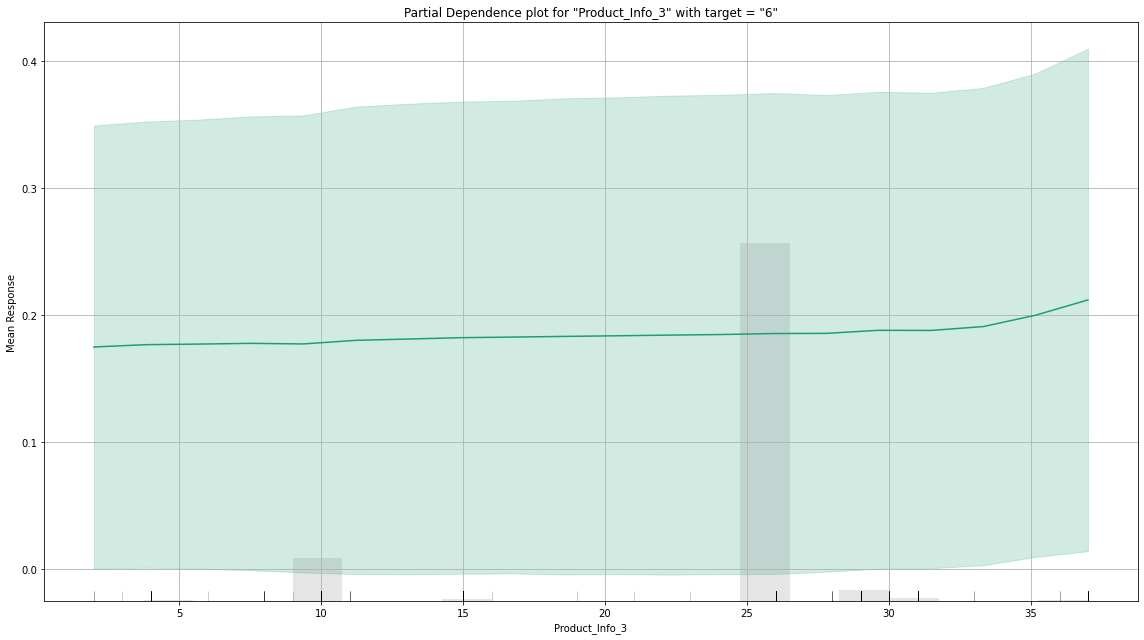

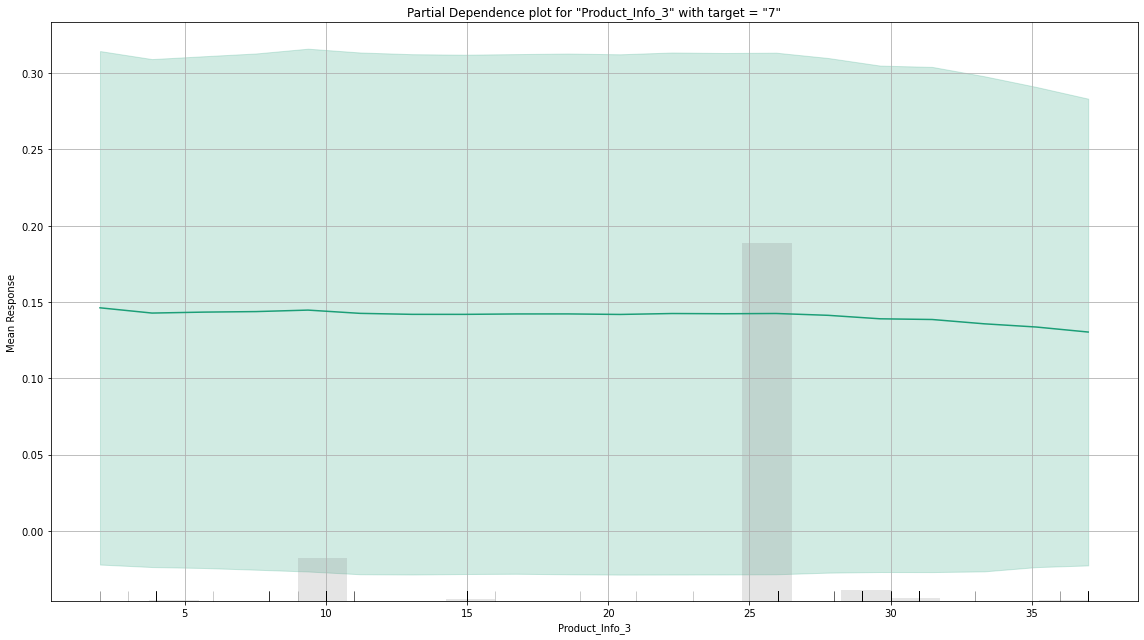

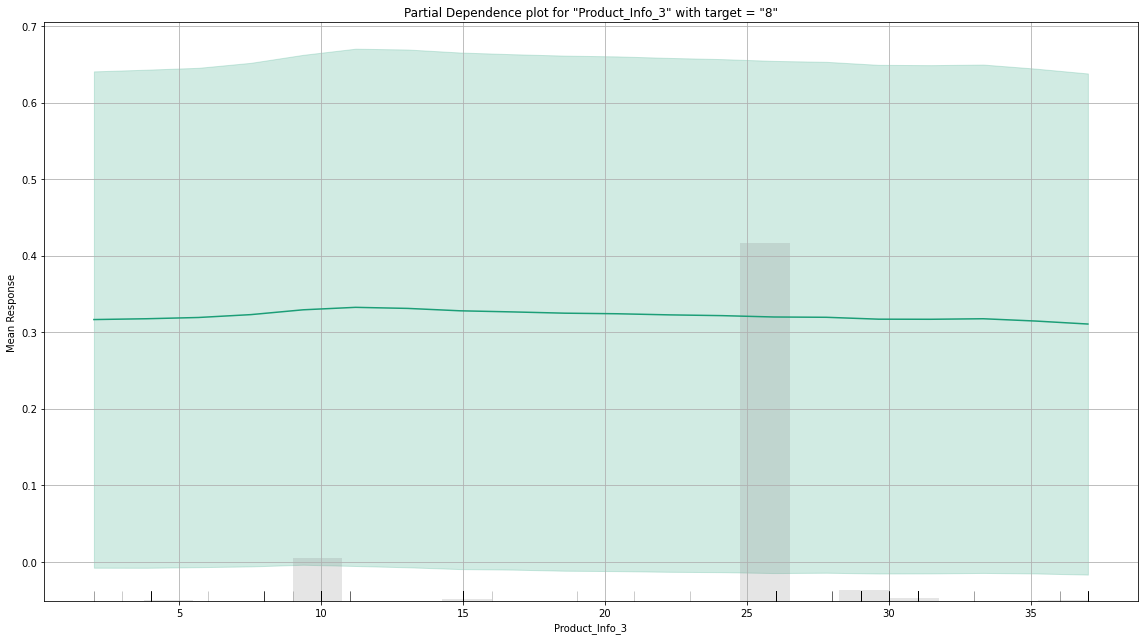

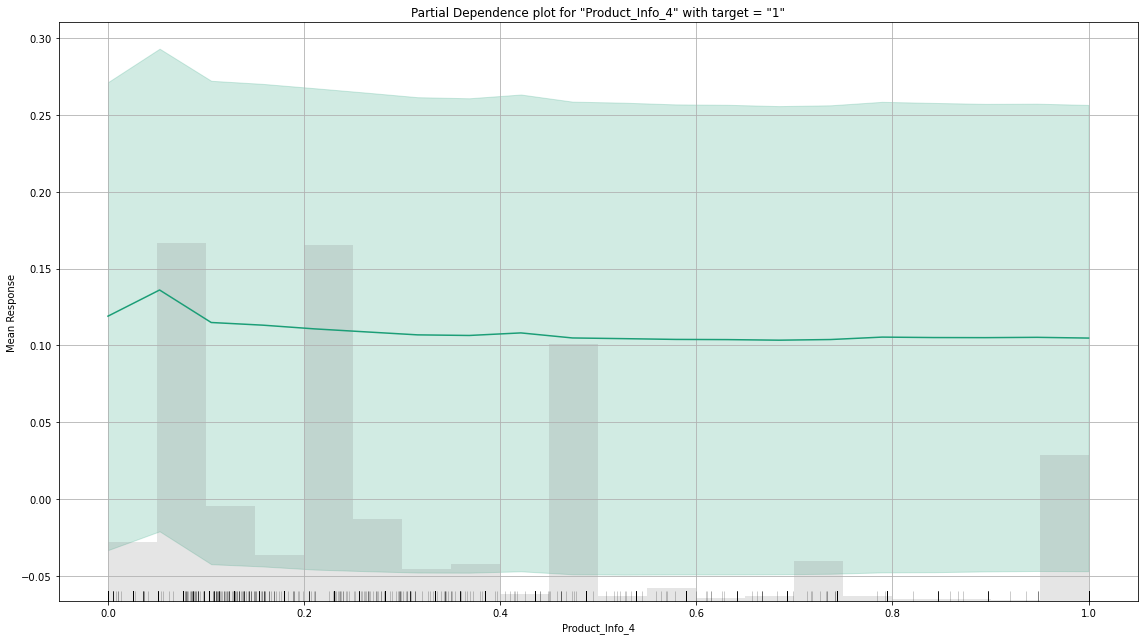

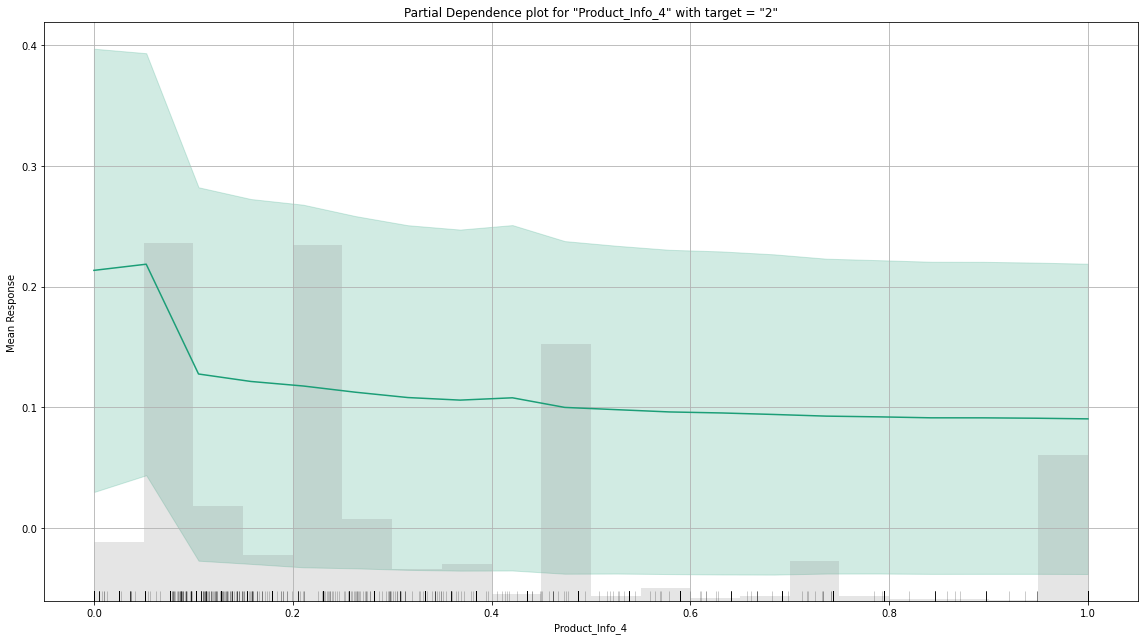

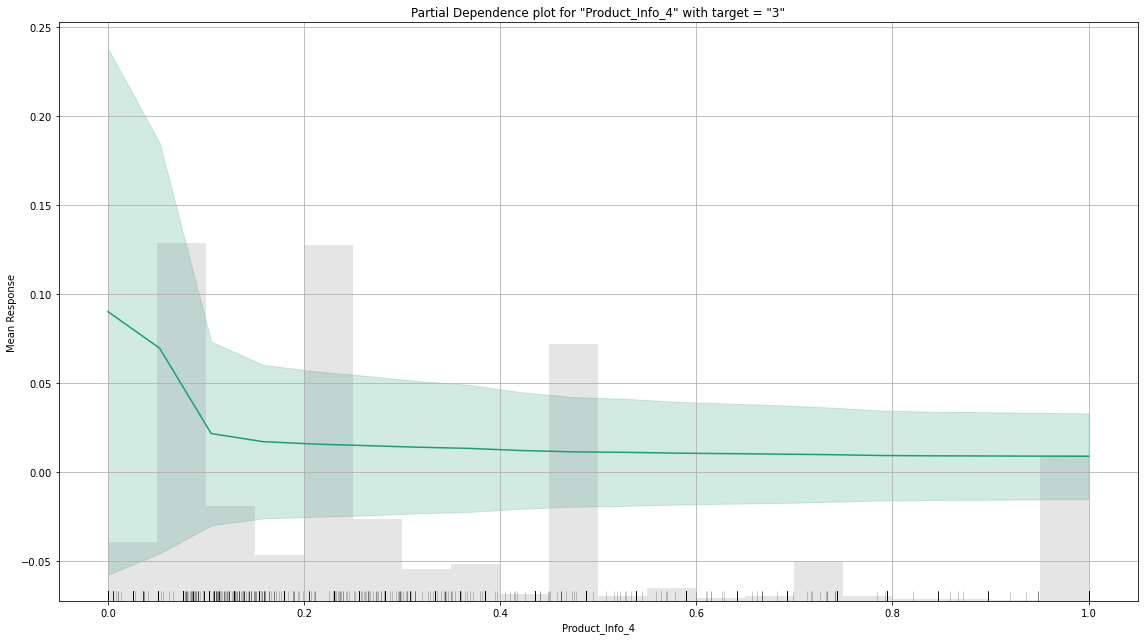

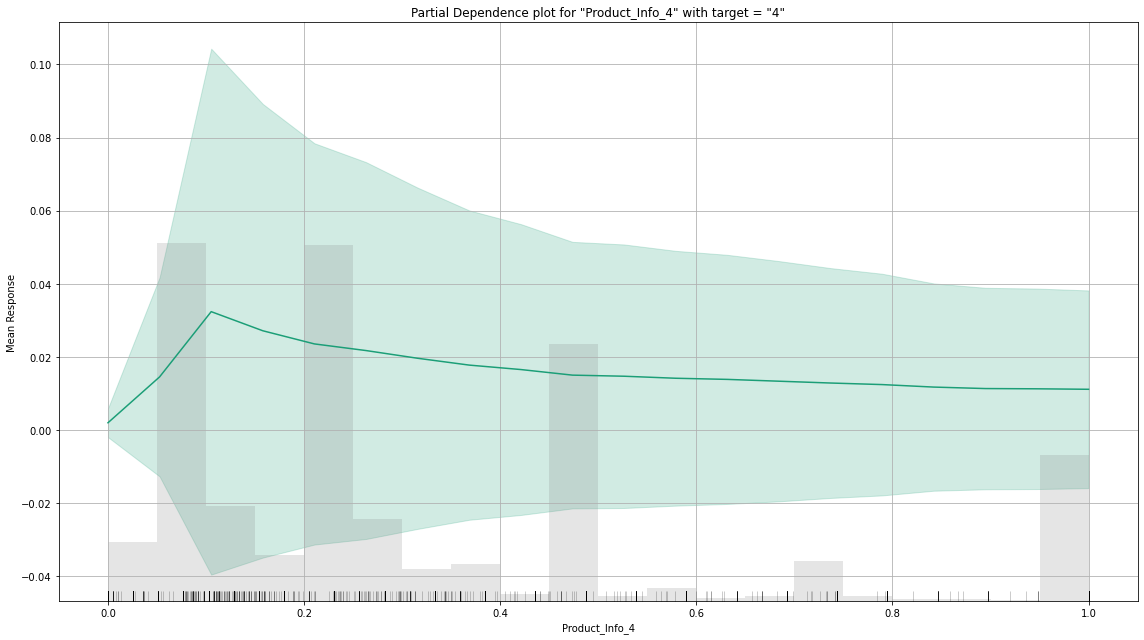

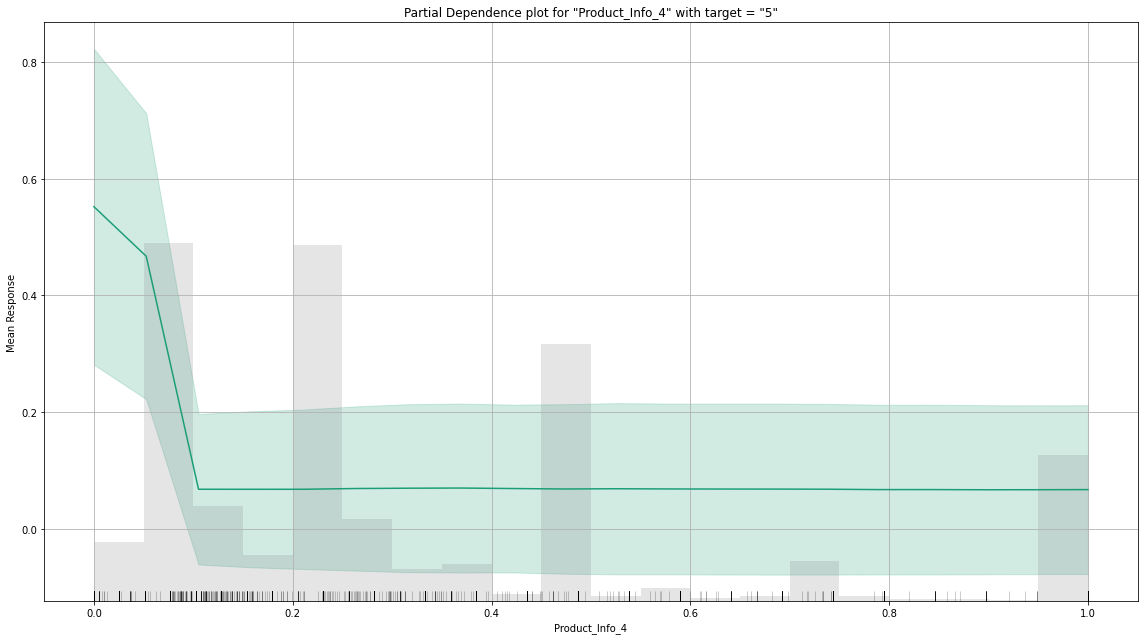

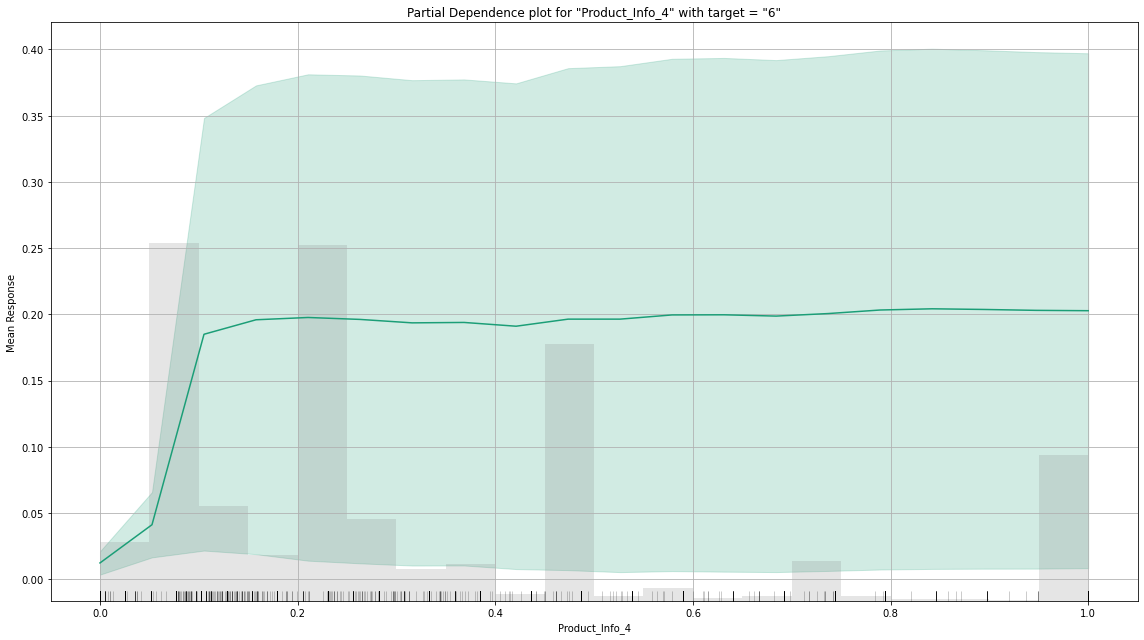

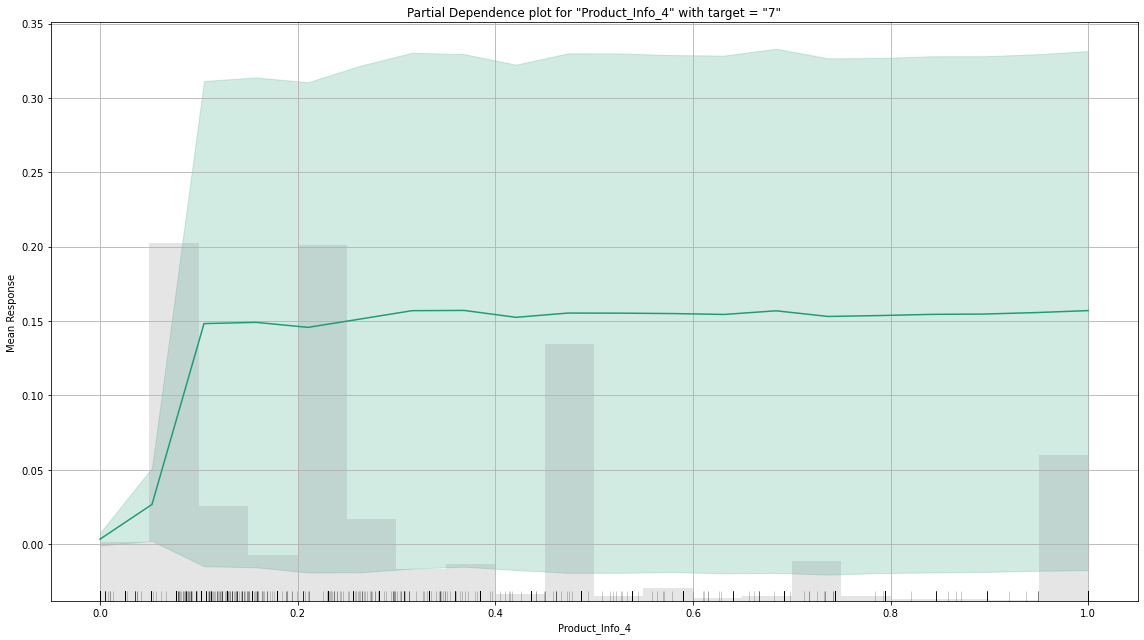

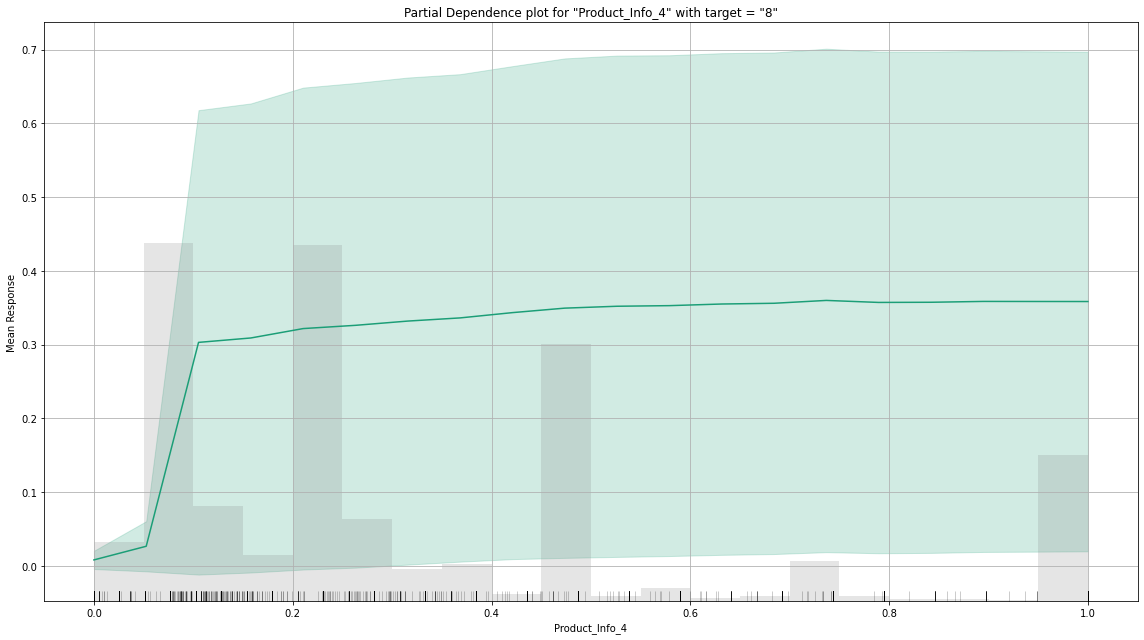

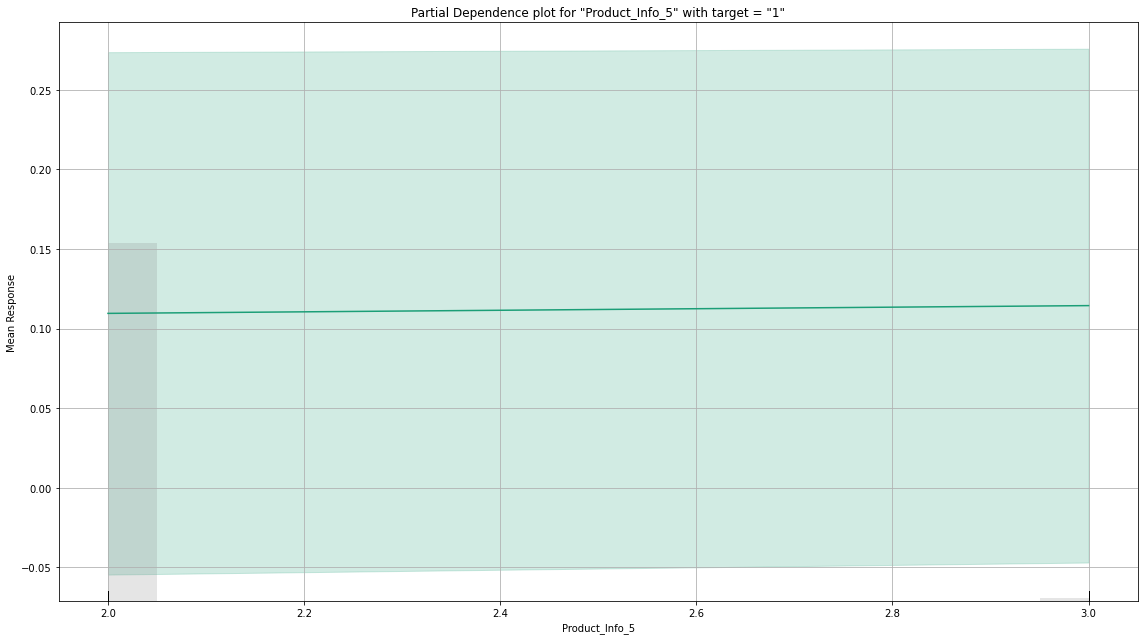

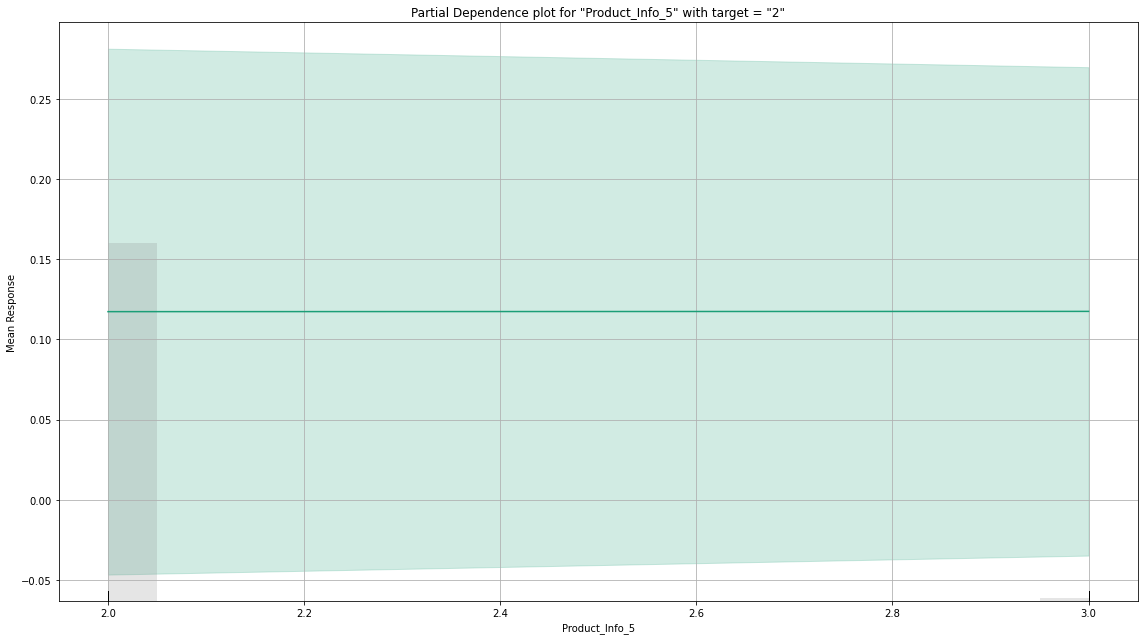

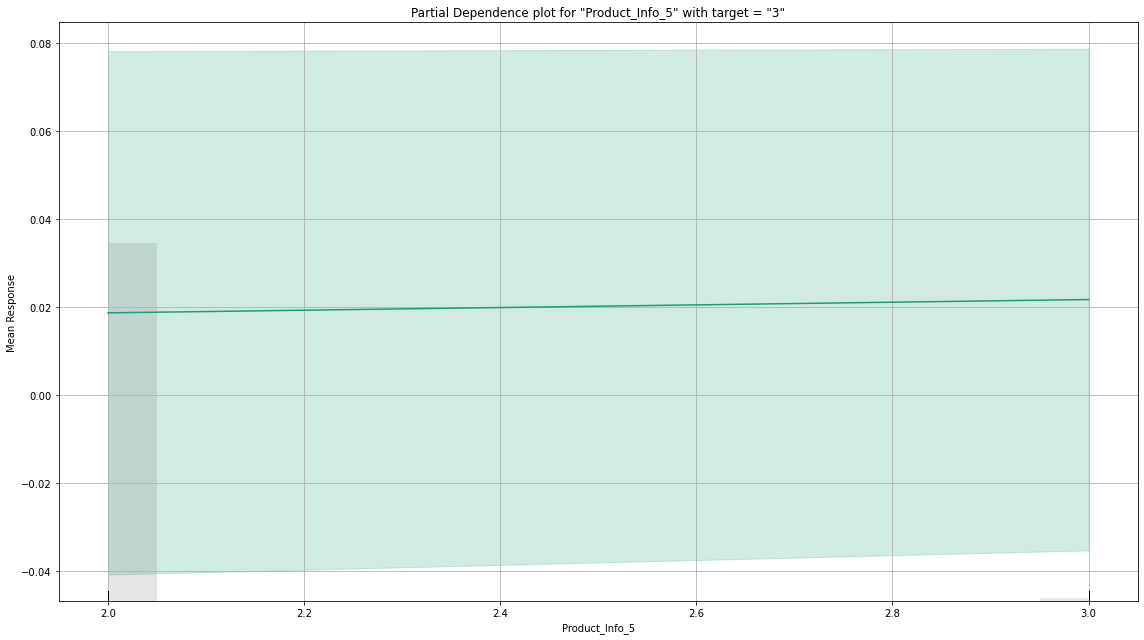

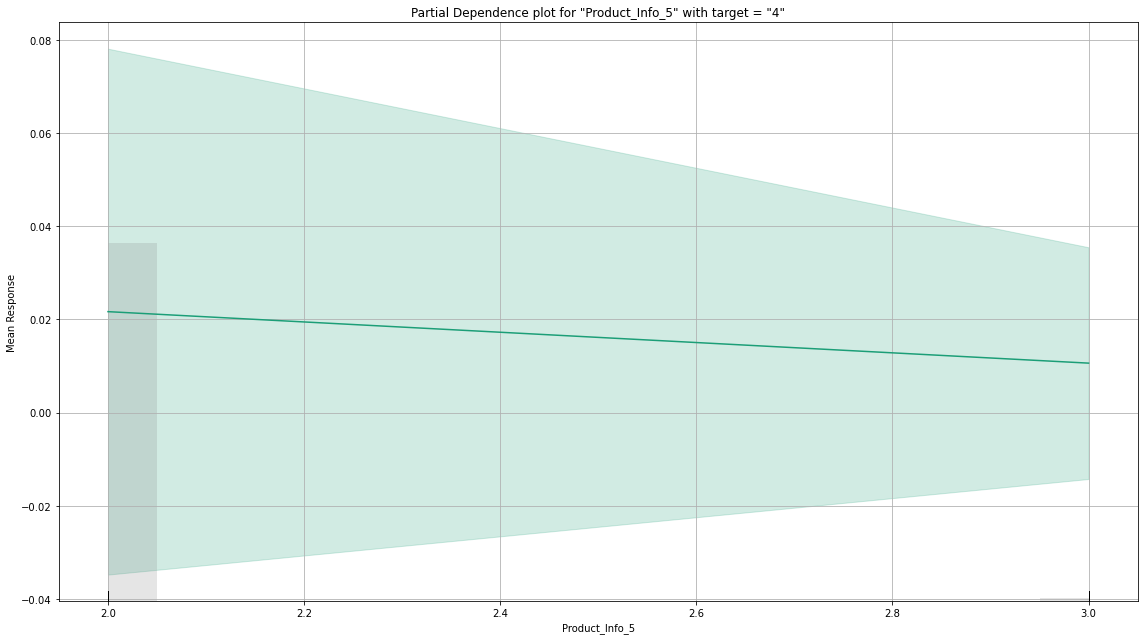

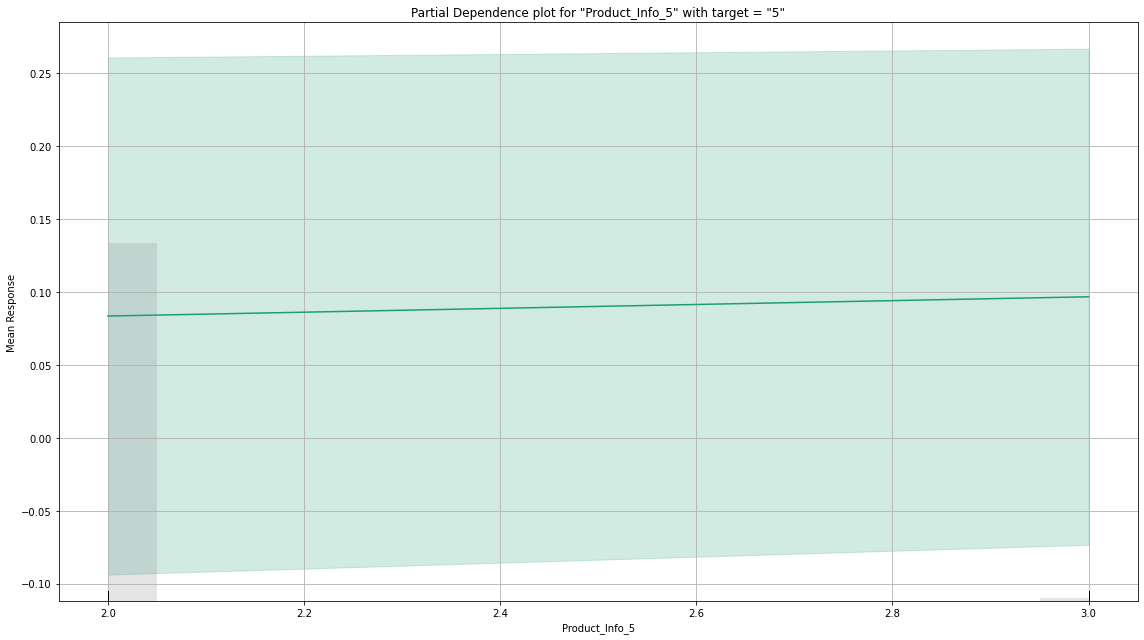

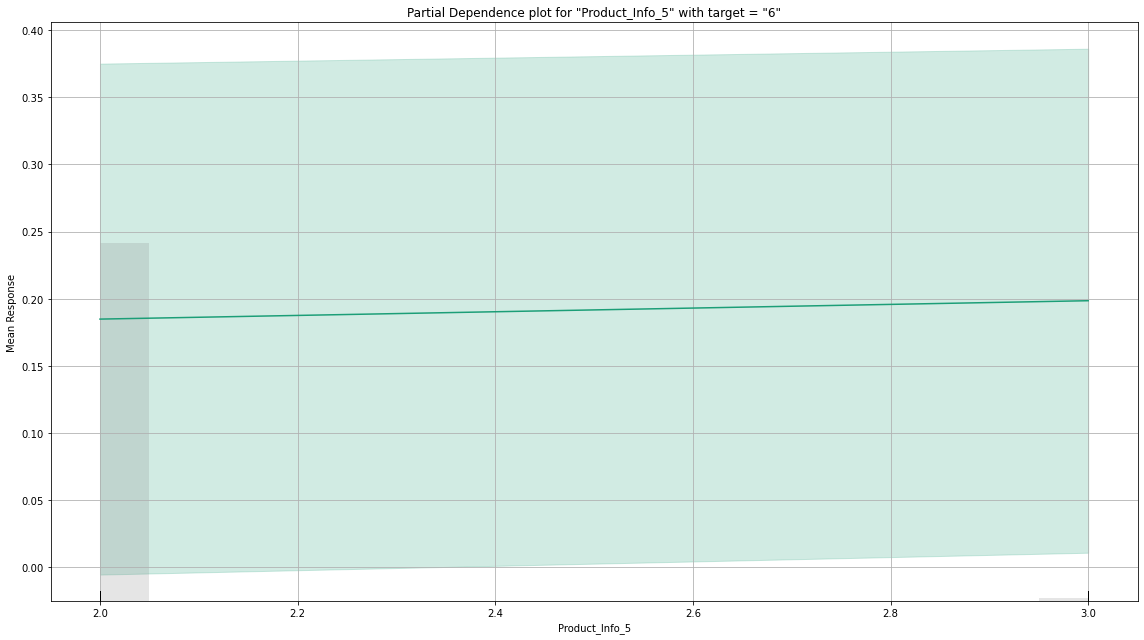

In [ ]:
# Explain a single H2O model (NOTE: This takes a long time to run)
exm = best_model.explain(val_frame)

#### ICE Plot

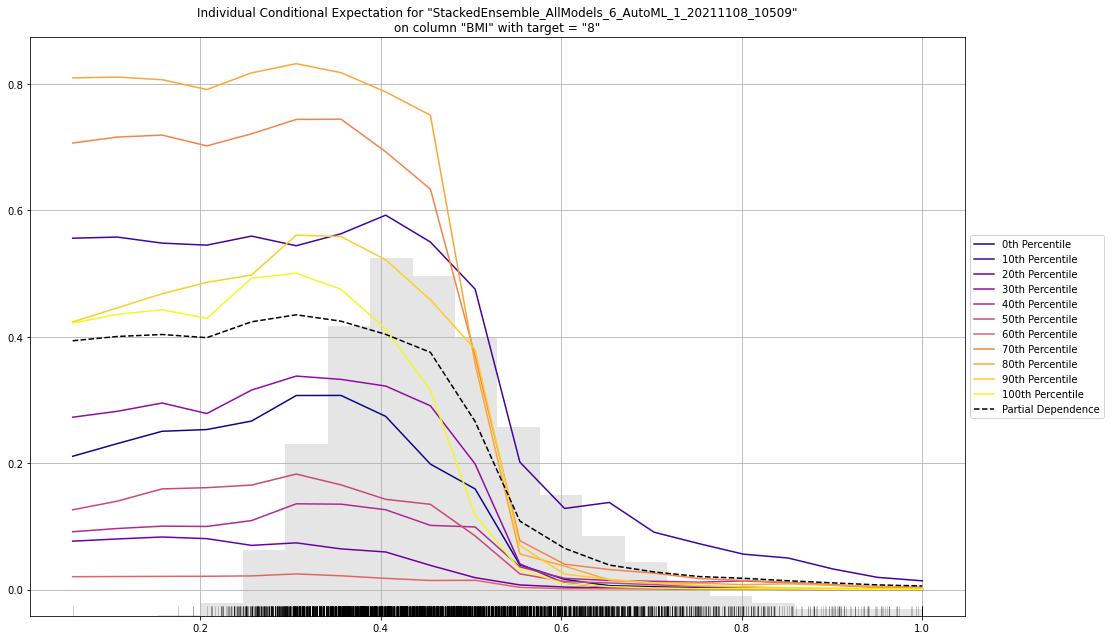

In [36]:
ice_plot = best_model.ice_plot(val_frame, target='8', column='BMI')

___
<a name="references"></a>
## (5) References

- https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html
- https://www.mlflow.org/docs/latest/python_api/mlflow.h2o.html
- https://h2o-release.s3.amazonaws.com/h2o/master/3888/docs-website/h2o-docs/save-and-load-model.html
- https://github.com/BogdanCojocar/medium-articles/blob/master/mlflow-automl/mlflow_automl.ipynb
- https://setscholars.net/automl-h2o-project-a-guide-to-build-a-multi-class-classification-model-in-python-using-car-description-data/
- https://stats.stackexchange.com/questions/276067/whats-considered-a-good-log-loss
- https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html#output-explanations